In [40]:
import numpy as np

# Create monkey patches
np.float = float
np.int = int
np.object = object
np.bool = bool

import pandas as pd
from sklearn.model_selection import train_test_split
from PopMusicInformationRetrieval import gunshot_utils as utils
import importlib
import torch as th
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from pydub.playback import play
import os
import torchaudio

importlib.reload(utils)

<module 'PopMusicInformationRetrieval.gunshot_utils' from '/Users/borosabel/Documents/Uni/Thesis/PopMusicInformationRetrieval/gunshot_utils.py'>

In [41]:
# This is how I initially built up the manually labeled gunshot dataset.
# folder_path = './test_data_wav/'
# gunshot_df = utils.build_dataframe_from_folder(folder_path)

In [42]:
# Loading the gunshot dataframe, which could be: 

# For now I just took the glock gunshots because they are the most clear and representative of how the gunshots usually are
# gunshot_df = pd.read_pickle('pkl_data/gunshot_data_glock_only.pkl')
# gunshot_df = gunshot_df[['filename', 'gunshot_location_in_seconds', 'num_gunshots']]

# Only the manually labeled gunshot samples.
gunshot_df = pd.read_pickle('pkl_data/real_music_gunshot_samples.pkl')
gunshot_df = gunshot_df[['filename', 'gunshot_location_in_seconds', 'num_gunshots']]

gunshot_df

,filename,gunshot_location_in_seconds,num_gunshots
0,./test_data_wav/Bomb First (My Second Reply).wav,"[69.626371, 69.846118, 70.079387, 70.336321, 7...",7
1,./test_data_wav/Waka Flocka Flame - Luv Dem Gu...,"[19.907719, 21.676554, 36.624089, 40.810785, 4...",37
2,./test_data_wav/Big L - Lifestylez Ov Da Poor ...,"[123.124869, 123.453186]",2
3,./test_data_wav/Kendrick Lamar - The Jig Is Up...,"[12.74289, 232.229388, 232.421346, 232.605306,...",6
4,./test_data_wav/Ghost.wav,"[86.839331, 137.936488, 138.31403, 138.48707, ...",6
5,./test_data_wav/Trashwang.wav,"[62.680021, 70.31747, 107.471155, 139.277666]",4
6,./test_data_wav/Ricky.wav,"[38.487809, 42.58123, 54.150832]",3
7,./test_data_wav/Meek Mill - Ooh Kill Em (Kendr...,"[63.76969, 64.281753]",2
8,./test_data_wav/Lupe Fiasco - Put You On Game.wav,"[27.146822, 61.745713, 61.827603, 94.85153, 11...",6
9,./test_data_wav/Dizzee Rascal - Hold Ya Mouf (...,"[1.757609, 2.102239, 2.504306]",3


In [74]:
# Loading the music dataframe, which could be: 
# - the dataframe where we store the musical onsets, exactly in a setup like how we have the gunshot locations.

music_df = pd.read_pickle('./pkl_data/music_with_onsets_df_100.pkl')
music_df.head()

,file_path,onsets_in_seconds,num_onsets
0,./Data/music/Beats to the Rhyme.wav,"[0.19736961451247165, 0.2786394557823129, 0.34...",927
1,./Data/music/Can't Knock The Hustle.wav,"[1.0332879818594105, 1.7414965986394557, 1.996...",1344
2,./Data/music/Down With the King.wav,"[0.25541950113378686, 0.4876190476190476, 0.53...",1580
3,./Data/music/All We Got Left Is The Beat.wav,"[0.3947392290249433, 0.6733786848072563, 0.743...",811
4,./Data/music/1nce Again (Radio Version).wav,"[0.4992290249433107, 2.6122448979591835, 3.308...",919


In [44]:
music_train_df, music_valid_df = train_test_split(music_df, test_size=0.2, random_state=42)
gunshot_train_df, gunshot_valid_df = train_test_split(gunshot_df, test_size=0.2, random_state=42)

In [45]:
print("SHAPES:")
print(f"music_train_df: {music_train_df.shape}, music_valid_df: {music_valid_df.shape}")
print(f"gunshot_train_df: {gunshot_train_df.shape}, gunshot_valid_df: {gunshot_valid_df.shape}")

SHAPES:
music_train_df: (80, 3), music_valid_df: (20, 3)
gunshot_train_df: (15, 3), gunshot_valid_df: (4, 3)


In [46]:
class GunshotDetectionCNN(nn.Module):
    def __init__(self, num_frames):
        super(GunshotDetectionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=(3, 7))
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 1))
        self.conv2 = nn.Conv2d(10, 20, kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 1))

        dummy_input = th.zeros(1, 3, 80, num_frames)
        dummy_output = self.pool2(F.relu(self.conv2(self.pool1(F.relu(self.conv1(dummy_input))))))
        output_size = dummy_output.view(-1).shape[0]

        self.fc1 = nn.Linear(output_size, 256)
        self.fc2 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)

        x = self.dropout(F.relu(self.fc1(x))) 
        x = self.sigmoid(self.fc2(x))
        return x

model = GunshotDetectionCNN(num_frames=utils.NUM_FRAMES)

In [47]:
class GunshotDataset(th.utils.data.Dataset):
    def __init__(self, music_df, gunshot_df, music_metadata, gunshot_prob=0.5, num_samples=1000, real_music_gunshot=False):
        super().__init__()
        self.music_paths = music_df['file_path'].tolist()
        self.music_onsets = music_df['onsets_in_seconds'].tolist()
        self.gunshot_paths = gunshot_df['filename'].tolist()
        self.gunshot_truth = gunshot_df['gunshot_location_in_seconds'].tolist()
        self.music_metadata = music_metadata
        self.gunshot_prob = gunshot_prob
        self.num_samples = num_samples # I created this parameter to be able to generate as many samples as we want, because for every song we have multiple onsets and for one gunshot we have multiple shots too.
        # This parameter is only because I also downloaded songs where I know that gunshot exists and in case I return a gunshot sample I don't want to combine an already good gunshot from a music with a music again.
        self.real_music_gunshot = real_music_gunshot 

    def __getitem__(self, idx):
        spectrograms = []
        labels = []

        # Randomly pick a music sample
        music_idx = np.random.randint(0, len(self.music_paths))
        fn_music = self.music_paths[music_idx]
        onset_times = self.music_onsets[music_idx]
        fn_music_metadata = self.music_metadata[fn_music]

        # Decide whether to add a gunshot or not
        add_gunshot = (np.random.rand() < self.gunshot_prob)

        if add_gunshot:
            # This is the scenario when the validation set consists only gunshots from real music.
            if self.real_music_gunshot:
                gunshot_idx = np.random.randint(0, len(self.gunshot_paths))
                fn_gunshot = self.gunshot_paths[gunshot_idx]
                gunshot_times = self.gunshot_truth[gunshot_idx]
                if len(gunshot_times) > 0:
                    gunshot_time = gunshot_times[np.random.randint(0, len(gunshot_times))]
                    gunshot_waveform, sr_gunshot = torchaudio.load(fn_gunshot)
                    gunshot_segment = utils.select_gunshot_segment(gunshot_waveform, sr_gunshot, gunshot_time)
                    gunshot_only_spectrograms, gunshot_only_labels = utils.preprocess_audio_train(gunshot_segment, label=1)
                    if gunshot_only_spectrograms and gunshot_only_labels:
                        spectrograms.extend(gunshot_only_spectrograms)
                        labels.extend(gunshot_only_labels)

            # This is the normal scenario when we have to combine music and gunshot
            else:
                gunshot_idx = np.random.randint(0, len(self.gunshot_paths))
                fn_gunshot = self.gunshot_paths[gunshot_idx]
                gunshot_times = self.gunshot_truth[gunshot_idx][0]
                music_waveform = utils.select_random_segment(file_path=fn_music, metadata=fn_music_metadata)
                segment, sr = utils.combine_music_and_gunshot(music_waveform, fn_gunshot, gunshot_times, gunshot_volume_increase_dB=0)
                combined_spectrograms, combined_labels = utils.preprocess_audio_train(segment, label=1)

                if combined_spectrograms and combined_labels:
                    spectrograms.extend(combined_spectrograms)
                    labels.extend(combined_labels)

        else:
            music_waveform = utils.select_valid_onset_segment(file_path=fn_music, metadata=fn_music_metadata, onset_times=onset_times)
            music_spectrograms, music_labels = utils.preprocess_audio_train(music_waveform, label=0)

            if music_spectrograms and music_labels:
                spectrograms.extend(music_spectrograms)
                labels.extend(music_labels)

        if not spectrograms or not labels:
            raise ValueError("Spectrograms or labels are empty after preprocessing")

        return spectrograms[0], labels[0]

    def get_random_music_with_gunshot(self):
        """
        Function to return a random waveform that contains both music and gunshot.
        """
        spectrograms = []

        if self.real_music_gunshot:
            gunshot_idx = np.random.randint(0, len(self.gunshot_paths))
            fn_gunshot = self.gunshot_paths[gunshot_idx]
            gunshot_times = self.gunshot_truth[gunshot_idx]
            if len(gunshot_times) > 0:
                gunshot_time = gunshot_times[np.random.randint(0, len(gunshot_times))]
                gunshot_waveform, sr_gunshot = torchaudio.load(fn_gunshot)
                segment = utils.select_gunshot_segment(gunshot_waveform, sr_gunshot, gunshot_time)
                gunshot_only_spectrograms, gunshot_only_labels = utils.preprocess_audio_train(segment, label=1)
                if gunshot_only_spectrograms and gunshot_only_labels:
                    spectrograms.extend(gunshot_only_spectrograms)

        else:
            music_idx = np.random.randint(0, len(self.music_paths))
            fn_music = self.music_paths[music_idx]
            onset_times = self.music_onsets[music_idx]
            fn_music_metadata = self.music_metadata[fn_music]
            # Select a random music segment
            music_waveform = utils.select_valid_onset_segment(file_path=fn_music, metadata=fn_music_metadata, onset_times=onset_times)
            # Randomly select a gunshot index
            gunshot_idx = np.random.randint(0, len(self.gunshot_paths))
            fn_gunshot = self.gunshot_paths[gunshot_idx]
            gunshot_times = self.gunshot_truth[gunshot_idx][0]
            segment, sr = utils.combine_music_and_gunshot(music_waveform, fn_gunshot, gunshot_times)
            combined_spectrograms, combined_labels = utils.preprocess_audio_train(segment, label=1)

            if combined_spectrograms and combined_labels:
                spectrograms.extend(combined_spectrograms)


        return segment, spectrograms[0]

    def get_random_music_onset(self):
        music_idx = np.random.randint(0, len(self.music_paths))
        fn_music = self.music_paths[music_idx]
        onset_times = self.music_onsets[music_idx]
        fn_music_metadata = self.music_metadata[fn_music]
        music_waveform = utils.select_valid_onset_segment(file_path=fn_music, metadata=fn_music_metadata, onset_times=onset_times)
        music_spectrograms, music_labels = utils.preprocess_audio_train(music_waveform, label=0)
        return music_waveform, music_spectrograms[0]

    def __len__(self):
        return self.num_samples  # Define the length of the dataset to be the number of samples you desire

In [59]:
music_metadata = utils.create_metadata_map('./Data/music')

In [60]:
music_metadata

{'./Data/music/Beats to the Rhyme.wav': {'sample_rate': 44100,
  'channels': 2,
  'duration': 160.73333333333332,
  'num_frames': 7088340},
 "./Data/music/Can't Knock The Hustle.wav": {'sample_rate': 44100,
  'channels': 2,
  'duration': 317.8,
  'num_frames': 14014980},
 './Data/music/Down With the King.wav': {'sample_rate': 44100,
  'channels': 2,
  'duration': 302.62666666666667,
  'num_frames': 13345836},
 './Data/music/All We Got Left Is The Beat.wav': {'sample_rate': 44100,
  'channels': 2,
  'duration': 277.96,
  'num_frames': 12258036},
 './Data/music/1nce Again (Radio Version).wav': {'sample_rate': 44100,
  'channels': 2,
  'duration': 229.22666666666666,
  'num_frames': 10108896},
 './Data/music/Can I Get A Witness.wav': {'sample_rate': 44100,
  'channels': 2,
  'duration': 216.66666666666666,
  'num_frames': 9555000},
 './Data/music/Beastie Boys - High Plains Drifter.wav': {'sample_rate': 44100,
  'channels': 2,
  'duration': 253.0046485260771,
  'num_frames': 11157505},
 '.

<b>Data Loader</b>

In [49]:
# I've made several changes in the dataloader: 

In [61]:
train_dataset = GunshotDataset(music_train_df, gunshot_train_df, music_metadata, gunshot_prob=0.5, num_samples=800, real_music_gunshot=True) # This means that with 50% probability it will generate gunshot samples. In total 800 samples.
valid_dataset = GunshotDataset(music_valid_df, gunshot_valid_df, music_metadata, gunshot_prob=0.5, num_samples=320, real_music_gunshot=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [62]:
# We can retrive also only gunshot parts and only musical onset parts for testing purposes like this: 

<b>Gunshot</b>

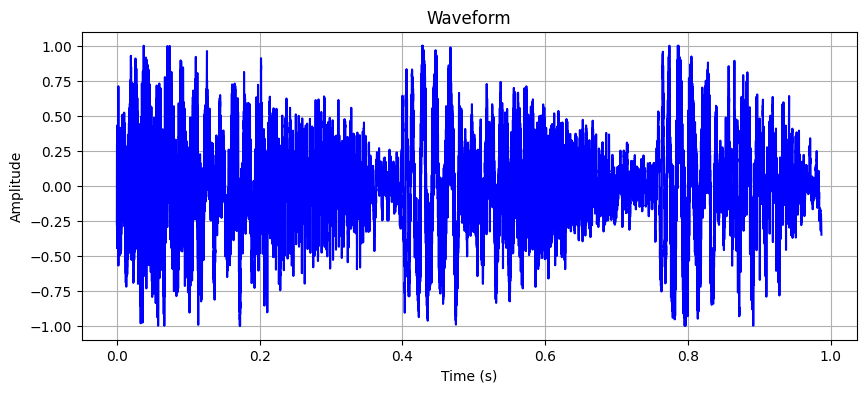

In [63]:
waveform, spectogram = train_dataset.get_random_music_with_gunshot() # retriving
utils.play_audio(waveform) # Listening to the excerpt
utils.plot_waveform(waveform) # Plotting the waveform

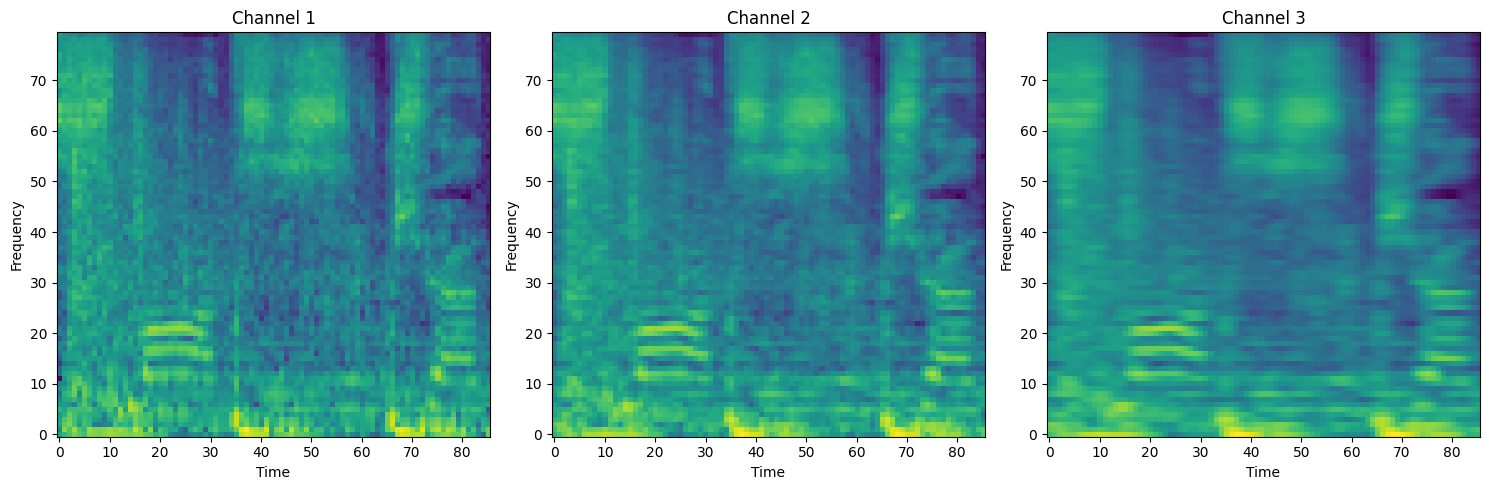

In [64]:
utils.plot_spectrogram_channels(spectogram) # Plotting the spectogram channels

<b>Music only</b>

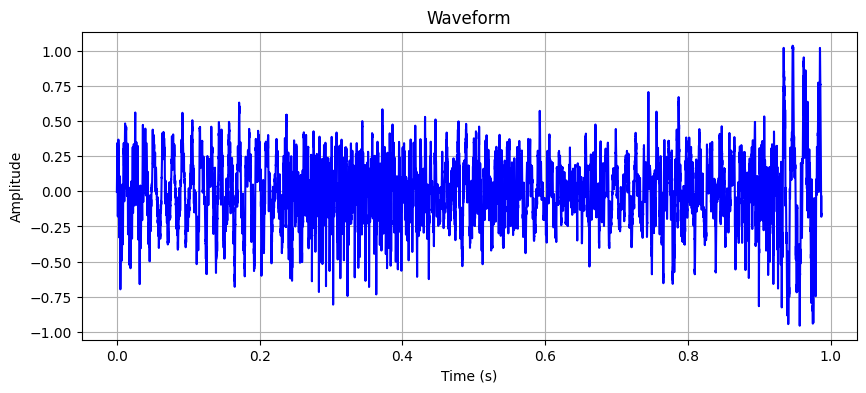

In [67]:
waveform, spectogram = train_dataset.get_random_music_onset() # retrieving
utils.play_audio(waveform) # Listening to the excerpt
utils.plot_waveform(waveform) # Plotting the waveform

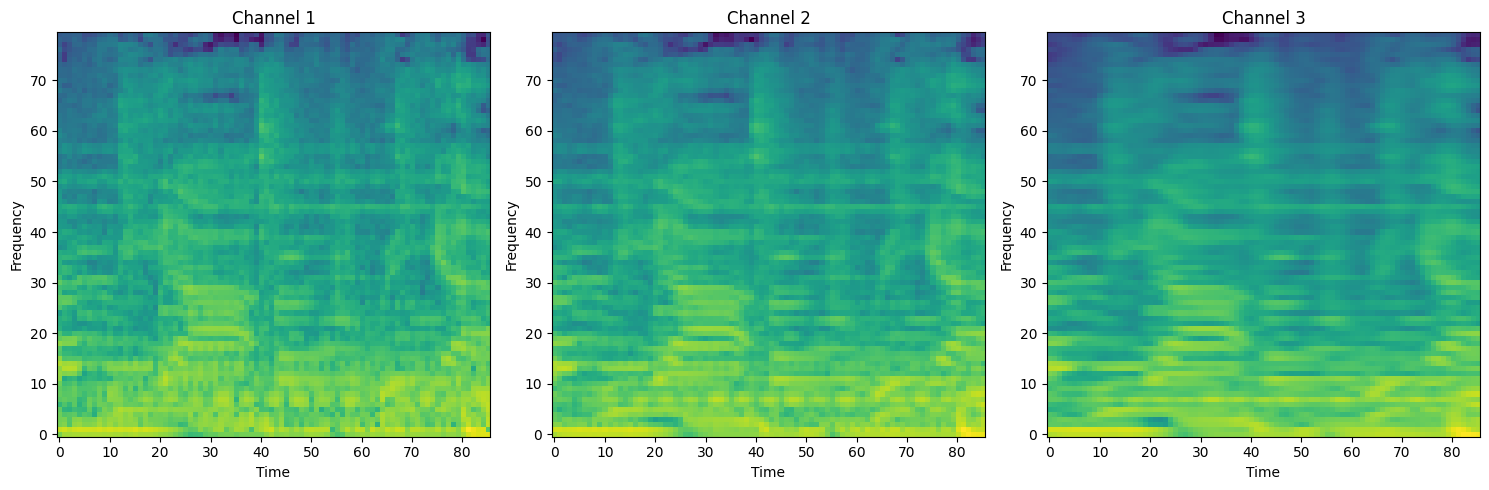

In [68]:
utils.plot_spectrogram_channels(spectogram) # Plotting the spectograms channels

<b>We can compare them like this</b>

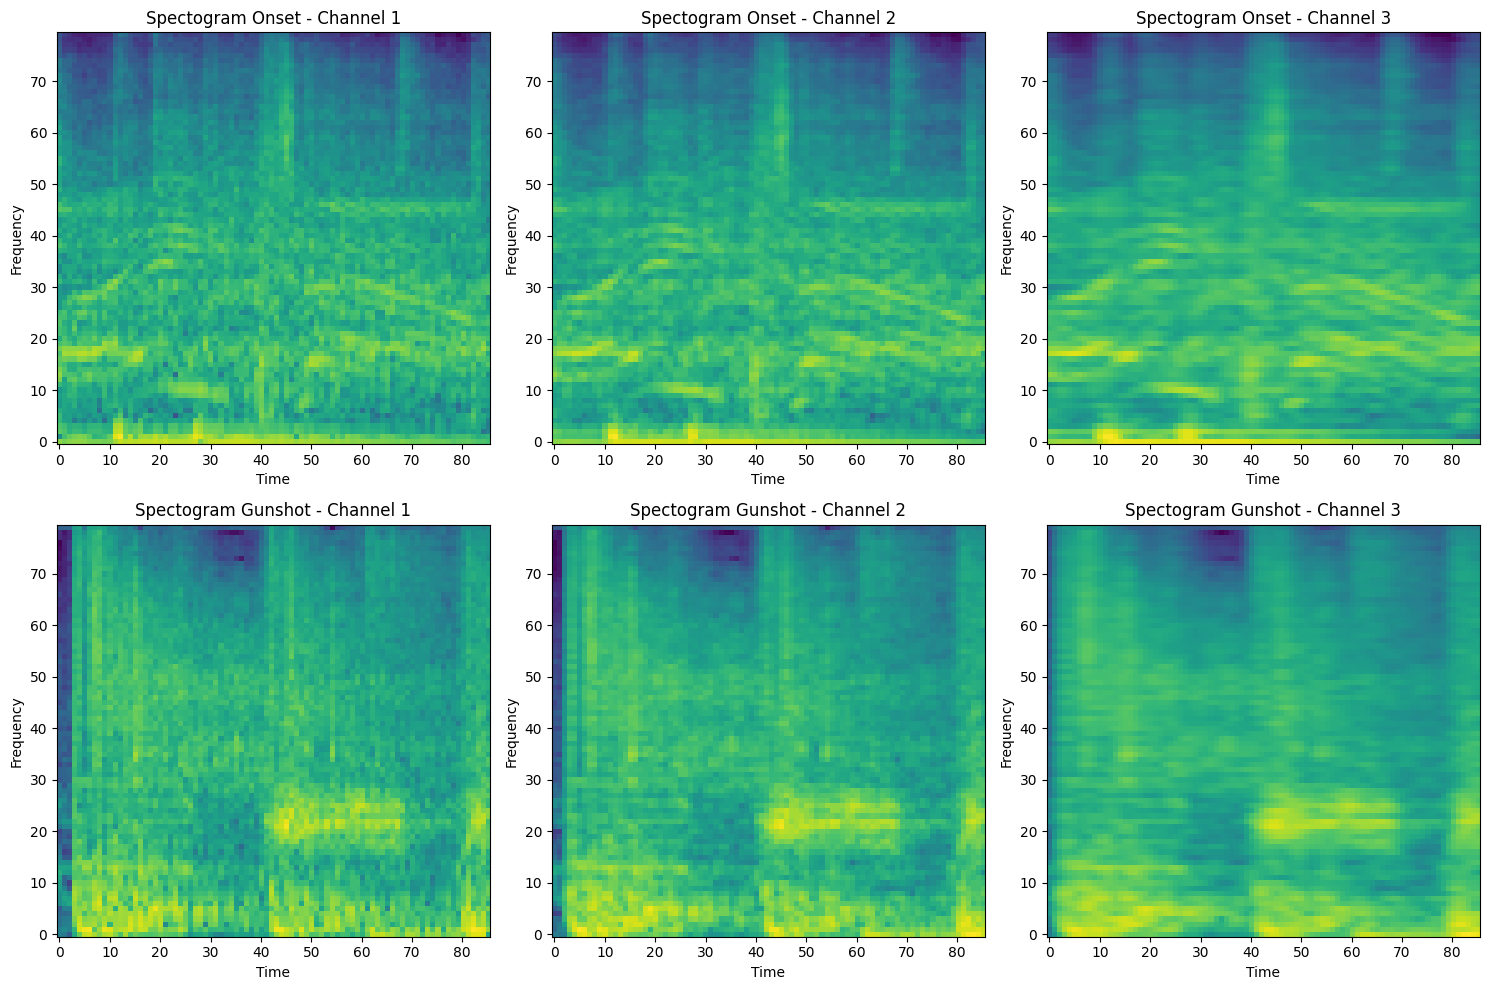

In [69]:
waveform_onset, spectogram_onset = train_dataset.get_random_music_onset() # retrieving
waveform_gunshot, spectogram_gun = train_dataset.get_random_music_with_gunshot() # retriving
utils.plot_spectrogram_channels_two_rows(spectogram_onset, spectogram_gun)

In [70]:
utils.play_audio(waveform_onset)

In [71]:
utils.play_audio(waveform_gunshot)

In [72]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")
use_cuda = th.cuda.is_available()
mean, std = utils.compute_mean_std(train_loader)
mean = mean.to(device)
std = std.to(device)

Computing mean and std: 100%|██████████| 25/25 [00:22<00:00,  1.09it/s]


Epoch [1] Training: 100%|██████████| 25/25 [00:22<00:00,  1.09it/s, loss=0.285]


Epoch [1], Loss: 0.4289


Validation: 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


Optimal threshold: 0.5183
New best f1: 0.9206, model saved.


Epoch [2] Training: 100%|██████████| 25/25 [00:22<00:00,  1.12it/s, loss=0.184]


Epoch [2], Loss: 0.2609


Validation: 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


Optimal threshold: 0.3599
New best f1: 0.9429, model saved.


Epoch [3] Training: 100%|██████████| 25/25 [00:22<00:00,  1.12it/s, loss=0.146] 


Epoch [3], Loss: 0.1754


Validation: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


Optimal threshold: 0.1991
New best f1: 0.9570, model saved.


Epoch [4] Training: 100%|██████████| 25/25 [00:22<00:00,  1.09it/s, loss=0.115] 


Epoch [4], Loss: 0.1492


Validation: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


Optimal threshold: 0.7307


Epoch [5] Training: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s, loss=0.0672]


Epoch [5], Loss: 0.1369


Validation: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Optimal threshold: 0.1729


Epoch [6] Training: 100%|██████████| 25/25 [00:24<00:00,  1.03it/s, loss=0.0332]


Epoch [6], Loss: 0.1010


Validation: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


Optimal threshold: 0.6788
No improvement in f1 for 3 epochs. Stopping training.


Computing Confusion Matrix: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


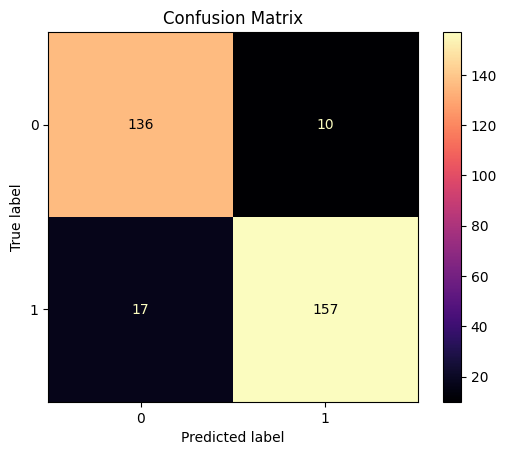

In [73]:
epochs = 10
lr = 3e-4

optimizer = th.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = th.nn.BCELoss()

best_threshold, best_score = utils.train_model(
    model, optimizer, criterion, train_loader, valid_loader, num_epochs=epochs, mean=mean, std=std, patience=3
)

In [77]:
spectrograms, sample_rates = utils.preprocess_audio(['./50 Cent - Many Men (Wish Death) (Dirty Version).mp3'])
print(f"Got back spectogram in shape: {spectrograms[0].shape} and sample rate: {sample_rates}")

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

Got back spectogram in shape: torch.Size([3, 80, 25617]) and sample rate: [44100]


In [78]:
predictions = utils.manual_evaluate_test(model, spectrograms[0], threshold=best_threshold, mean=mean, std=std, step_size=1, filter_time_sec=1)

if(len(predictions) > 0):
    print(f"Current treshold is {best_threshold} \n")

    for minutes, seconds, output in predictions:
        print(f"Detected gunshot at {minutes}m {seconds:.2f}s with model output: {output:.4f}")
else:
    print("No predictions")

Number of predictions 25532
Found 15019 gunshot samples.
Current treshold is 0.1991056501865387 

Detected gunshot at 0m 2.59s with model output: 0.3001
Detected gunshot at 0m 3.66s with model output: 0.2249
Detected gunshot at 0m 5.46s with model output: 0.2090
Detected gunshot at 0m 6.47s with model output: 0.6820
Detected gunshot at 0m 7.48s with model output: 0.2485
Detected gunshot at 0m 8.49s with model output: 0.9528
Detected gunshot at 0m 9.62s with model output: 0.2015
Detected gunshot at 0m 10.63s with model output: 0.6590
Detected gunshot at 0m 11.64s with model output: 0.3142
Detected gunshot at 0m 12.65s with model output: 0.9853
Detected gunshot at 0m 13.66s with model output: 0.9992
Detected gunshot at 0m 23.24s with model output: 0.5228
Detected gunshot at 0m 33.58s with model output: 0.2059
Detected gunshot at 0m 38.29s with model output: 0.2094
Detected gunshot at 0m 41.09s with model output: 0.2868
Detected gunshot at 0m 42.40s with model output: 0.2048
Detected guns

In [79]:
# For this song above we should have gunshots at around: 
# -0:12
# -0:47
# -2:04 
# instead of these we have a bunch of predictions